# ML1 Regression Project - `traffic` dataset

Completed by:
- Vadym Dudarenko (Student ID 444820)
- Vladimir Shargin (Student ID 437981)

## Dataset description

- date_time – date and time (1 hourly interval)
- weather_general – general short description of the current weather with the following levels: Clear, Clouds, Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow, Squall, Thunderstorm
- weather_detailed – more detailed description of the current weather with the following levels: broken clouds, drizzle, few clouds, fog, freezing rain, haze, heavy intensity drizzle, heavy intensity rain, heavy snow, light intensity drizzle, light intensity shower rain, light rain, light rain and snow, light shower snow, light snow, mist, moderate rain, overcast clouds, proximity shower rain, proximity thunderstorm, proximity thunderstorm with drizzle, proximity thunderstorm with rain, scattered clouds, shower drizzle, shower snow, sky is clear, sleet, smoke, snow, squalls, thunderstorm, thunderstorm with drizzle, thunderstorm with heavy rain, thunderstorm with light drizzle, thunderstorm with light rain, thunderstorm with rain, very heavy rain
- clouds_coverage – percentage of sky covered by the clouds in the hourly interval
- temperature – average temperature in the hourly interval (in Celsius degrees)
- rain_mm – amount of rain that occurred in the hourly interval (in mm)
- snow_mm – amount of snow that occurred in the hourly interval (in mm)
- traffic – the amount of traffic in the hourly interval (**outcome variable**, only in the training sample)

## Library imports

In [1]:
import pandas as pd

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

import catboost

import seaborn as sns

import matplotlib.pyplot as plt

## Reading data

In [2]:
traffic_df = pd.read_csv('data/traffic_train.csv', parse_dates=['date_time'])

In [3]:
traffic_df.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


## EDA

Before applying any machine learning algorithms we need to examine what the data is, check for missing values, outliers, distributions, etc.

There are 29701 observations with no missing values. The dataset has one datetime column (`date_time`), two categorical columns (`weather_general`, `weather_detailed`) and five continuous columns (`clouds_coverage_pct`, `temperature`, `rain_mm`, `snow_mm`, `traffic`).

In [4]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29701 entries, 0 to 29700
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            29701 non-null  datetime64[ns]
 1   weather_general      29701 non-null  object        
 2   weather_detailed     29701 non-null  object        
 3   clouds_coverage_pct  29701 non-null  int64         
 4   temperature          29701 non-null  float64       
 5   rain_mm              29701 non-null  float64       
 6   snow_mm              29701 non-null  float64       
 7   traffic              29701 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 1.8+ MB


Descriptive statistics for the dataset:

In [5]:
traffic_df.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,29701.000000,29701.000000,29701.000000,29701.000000,29701.000000
mean,50.210027,7.500451,0.509914,0.000361,3228.196761
std,38.657342,13.769115,57.058322,0.010403,1989.059081
min,0.000000,-273.100000,0.000000,0.000000,0.000000
25%,1.000000,-1.300000,0.000000,0.000000,1159.000000
50%,64.000000,8.300000,0.000000,0.000000,3309.000000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,9831.300000,0.510000,7263.000000


There are definitely some outliers in temperature which we'd like to remove (-273.1 degrees Celsius is absolute zero) and rainfall (9831.3 mm/hour is an impossible figure)

In [6]:
def clean_df(df: pd.DataFrame, train_data: bool=True) -> pd.DataFrame:
    if train_data:
        df = df[df['temperature'] != -273.1]
        df = df[df['rain_mm'] != 9831.3]
    return df

In [7]:
traffic_df = clean_df(traffic_df)

In [8]:
traffic_df.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,29690.000000,29690.000000,29690.000000,29690.000000,29690.000000
mean,50.226103,7.594237,0.178971,0.000361,3228.762243
std,38.653249,12.771607,1.233615,0.010405,1988.896490
min,0.000000,-29.800000,0.000000,0.000000,0.000000
25%,1.000000,-1.200000,0.000000,0.000000,1161.500000
50%,64.000000,8.300000,0.000000,0.000000,3310.500000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,55.630000,0.510000,7263.000000


The data spans 4 years and 2 months (from October 2014 to December 2018).

In [9]:
traffic_df['date_time'].min(), traffic_df['date_time'].max()

(Timestamp('2014-10-01 00:00:00'), Timestamp('2018-12-31 23:00:00'))

Target variable `traffic` distribution is not normal, there are several peaks: the largest peak around 250 cars/hour and two smaller ones around 2750 cars/hour and 4500 cars/hour

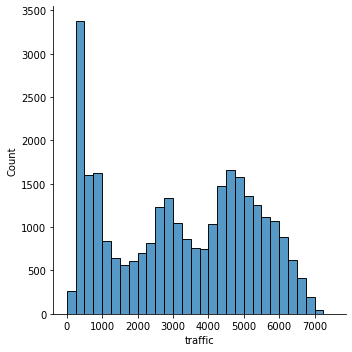

In [10]:
sns.displot(data=traffic_df, x='traffic', binwidth=250)

Daily traffic also shows a non-normal distribution, with a peak around 75000 cars/day.

<AxesSubplot:ylabel='Count'>

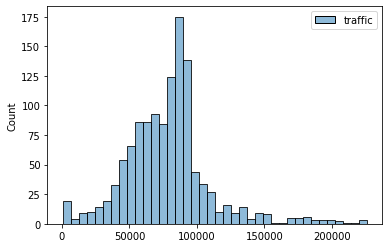

In [11]:
sns.histplot(traffic_df.groupby(traffic_df.date_time.dt.strftime('%Y-%m-%d')).agg({'traffic': 'sum'}))

Distribution of traffic over hours:

<AxesSubplot:xlabel='traffic', ylabel='Count'>

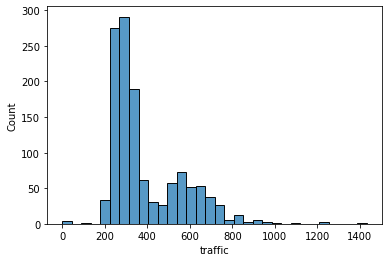

In [12]:
sns.histplot(traffic_df[traffic_df.date_time.dt.hour == 2]['traffic'])

Change in traffic over years:

- There is an irregular pattern: traffic doesn't grow YoY, there is a peak around 2015 that is almost equal to 2018)

<AxesSubplot:xlabel='date_time', ylabel='traffic'>

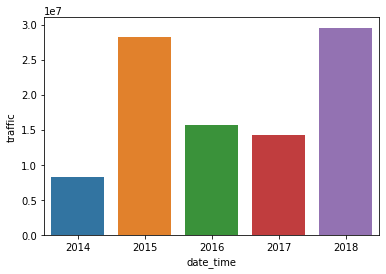

In [13]:
sns.barplot(data=traffic_df, x=traffic_df.date_time.dt.year, y='traffic', estimator=sum, ci=None)

We should also explore if there are any seasonal patterns in the traffic.

Hourly seasonality:

- Morning and evning peak hours are 7 and 16. Time might be UTC and the actual location might be in UTC+1 or UTC+2 timezone, which would give the more expected peak hours 8/9 in the morning and 17/18 in the evening.
- Low traffic during the evening and night (from 19 to 5)

<AxesSubplot:xlabel='date_time', ylabel='traffic'>

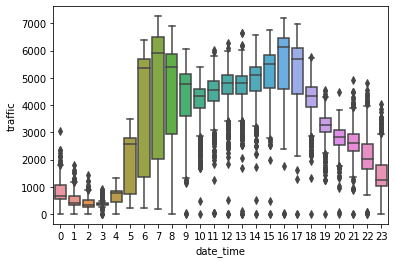

In [14]:
sns.boxplot(data=traffic_df, y='traffic', x=traffic_df.date_time.dt.hour)

Weekly seasonality:

<AxesSubplot:xlabel='date_time', ylabel='traffic'>

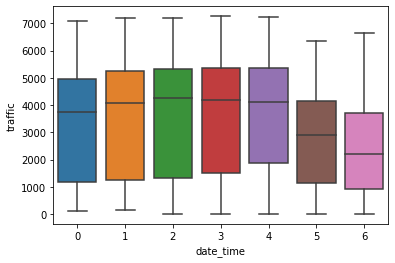

In [15]:
sns.boxplot(data=traffic_df, y='traffic', x=traffic_df.date_time.dt.dayofweek)

Monthly seasonality:

<AxesSubplot:xlabel='date_time', ylabel='traffic'>

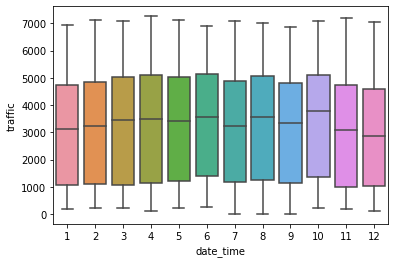

In [16]:
sns.boxplot(data=traffic_df, y='traffic', x=traffic_df.date_time.dt.month)

<AxesSubplot:xlabel='week', ylabel='traffic'>

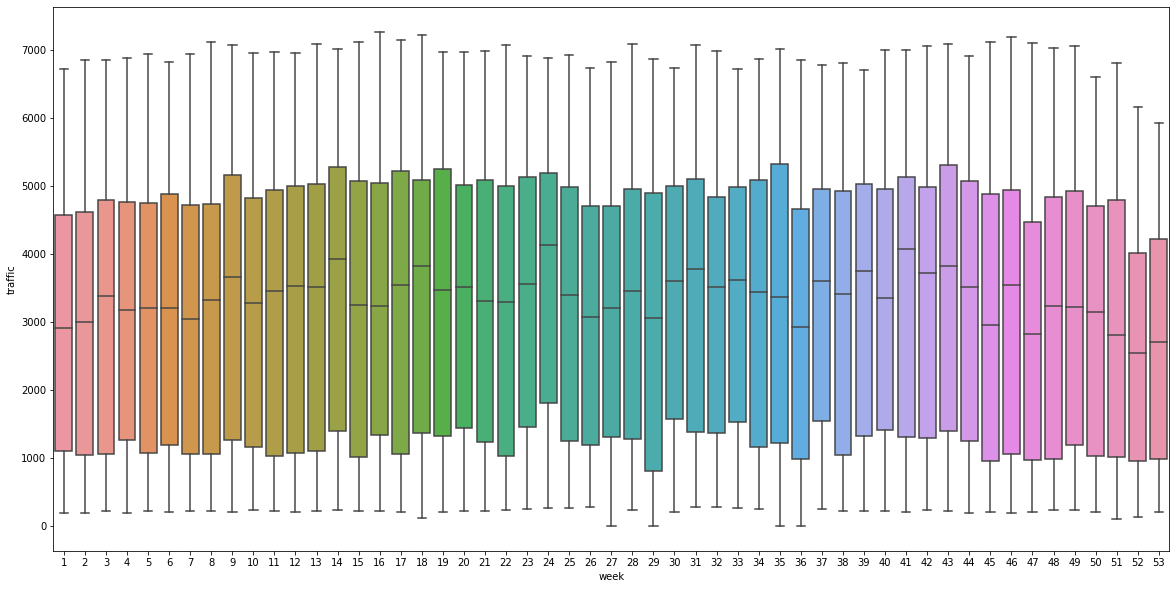

In [17]:
plt.figure(figsize=(20,10))
sns.boxplot(data=traffic_df, y='traffic', x=traffic_df.date_time.dt.isocalendar().week)

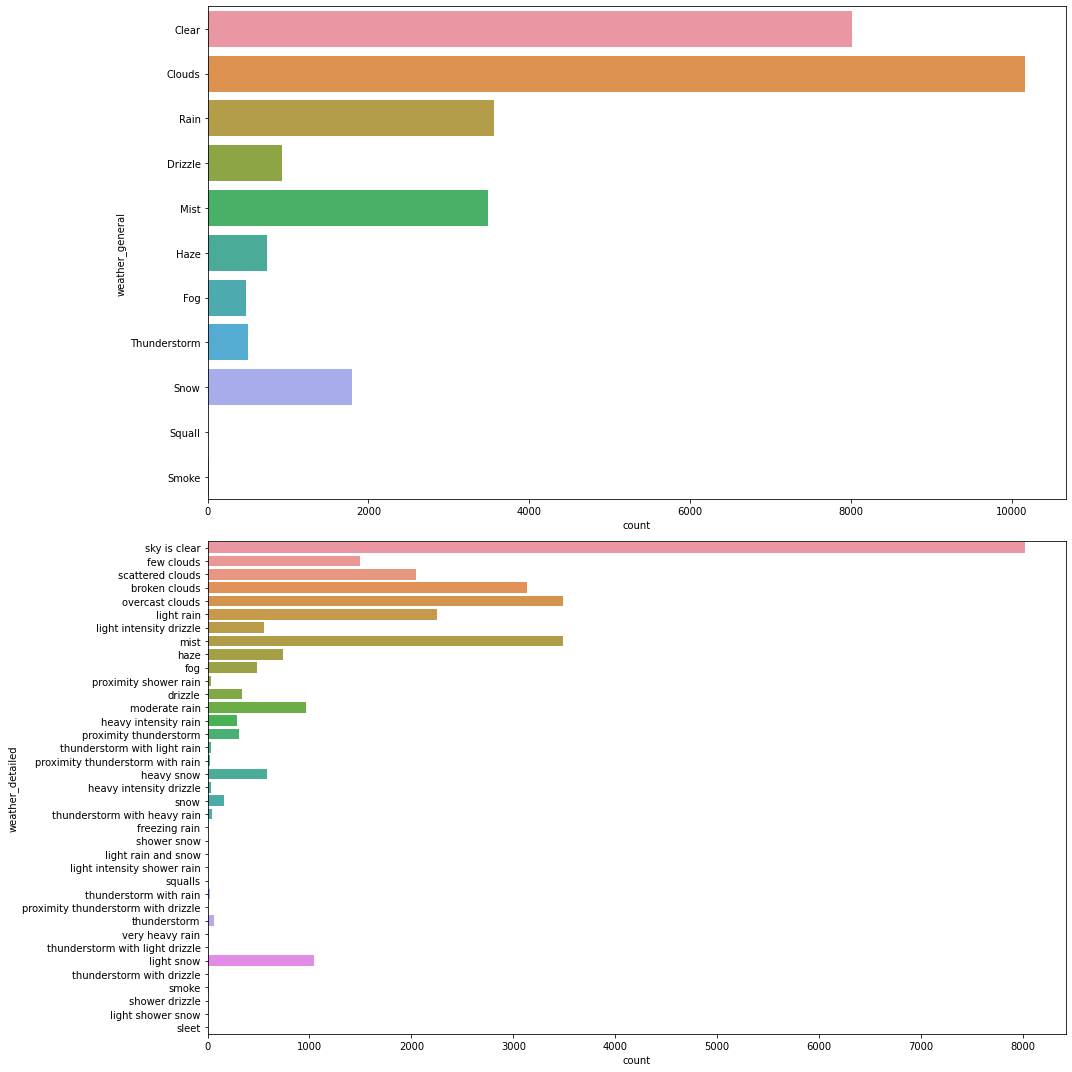

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

for i, weather_feature in enumerate(['weather_general', 'weather_detailed']):
    sns.countplot(y=traffic_df[weather_feature], ax=ax[i], orient='h')

plt.tight_layout()

## Feature engineering

Since there is some seasonal pattern from hours, days of the week and months we should add those features to our dataset:

In [19]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(hour=df['date_time'].dt.hour)
    df = df.assign(month=df['date_time'].dt.month)
    df = df.assign(dayofweek=df['date_time'].dt.dayofweek)
    return df

In [20]:
traffic_df = feature_engineering(traffic_df)

## General remarks

All models follow the same pipeline:

1) Split the dataset into training/test sets (70/30 split)
2) Preprocess the data if needed (categorical feature encoding, numeric feature scaling)
3) Fine-tune hyperparameters for the models using grid search with 5-fold cross-validation
4) Model is retrained on the whole training set using the best hyperparameters obtained using grid search
5) Balanced accuracy is compared on the training and test sets to check for overfitting

The best model is chosen by MAPE (lower is better) on the test set

## Dataset train-test split

In [21]:
cat_features = ['weather_general', 'weather_detailed', 'hour', 'month', 'dayofweek']
num_features = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm']

target = 'traffic'

In [22]:
X = traffic_df[cat_features + num_features]
y = traffic_df[target]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [24]:
X_train

,weather_general,weather_detailed,hour,month,dayofweek,clouds_coverage_pct,temperature,rain_mm,snow_mm
21391,Clouds,scattered clouds,15,2,5,40,4.1,0.0,0.0
24712,Clouds,broken clouds,10,7,2,75,22.9,0.0,0.0
26533,Clear,sky is clear,6,9,0,1,16.0,0.0,0.0
4585,Clear,sky is clear,12,3,3,1,3.6,0.0,0.0
21355,Haze,haze,12,2,3,1,2.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...
21585,Clouds,overcast clouds,23,3,3,90,-0.6,0.0,0.0
5390,Rain,light rain,19,4,0,90,7.9,0.0,0.0
860,Clouds,overcast clouds,22,11,5,90,2.5,0.0,0.0
15805,Clear,sky is clear,9,7,3,1,20.4,0.0,0.0


To make our life easier down the road when we calculate MAPE we'll make subsets of train/test sets without observations where `traffic` is 0. There are 16 such observations and we can safely ignore them when estimating model quality.

In [25]:
X_train_for_mape = X_train[y_train != 0]
y_train_for_mape = y_train[y_train != 0]

X_test_for_mape = X_test[y_test != 0]
y_test_for_mape = y_test[y_test != 0]

## Baseline

Naive approach to the task: predict mean for all observations

In [26]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)

DummyRegressor()

In [27]:
mean_absolute_percentage_error(y_train_for_mape, dummy_regressor.predict(X_train_for_mape))

2.4603248877807173

In [28]:
mean_absolute_percentage_error(y_test_for_mape, dummy_regressor.predict(X_test_for_mape))

2.9097815864901997

## Linear regression

Linear regression is one of the simplest (and often very effective) approaches to regression tasks

In [29]:
ohe_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()
transformers = ColumnTransformer([('categorical', ohe_transformer, cat_features),
                                  #('hour_sin', sin_transformer(24), ['hour']),
                                  #('hour_cos', cos_transformer(24), ['hour']),
                                  #('month_sin', sin_transformer(12), ['month']),
                                  #('month_cos', cos_transformer(12), ['month']),
                                  #('dayofweek_sin', sin_transformer(7), ['dayofweek']),
                                  #('dayofweek_cos', cos_transformer(7), ['dayofweek']),
                                  #('week_sin', sin_transformer(52), ['week']),
                                  #('week_cos', cos_transformer(52), ['week']),
                                  ('numeric', scaler, num_features)], remainder='passthrough')
linreg_pipeline = Pipeline(steps=[('transform', transformers),
                                  ('logreg', LinearRegression())])

In [30]:
linreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['weather_general',
                                                   'weather_detailed', 'hour',
                                                   'month', 'dayofweek']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['clouds_coverage_pct',
                                                   'temperature', 'rain_mm',
                                                   'snow_mm'])])),
                ('logreg', LinearRegression())])

In [31]:
mean_absolute_percentage_error(y_train_for_mape, linreg_pipeline.predict(X_train_for_mape))

0.9703684624807202

In [32]:
mean_absolute_percentage_error(y_test_for_mape, linreg_pipeline.predict(X_test_for_mape))

c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1.2877860217746266

## Ridge

In [33]:
ohe_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()
transformers = ColumnTransformer([('categorical', ohe_transformer, cat_features),
                                  ('numeric', scaler, num_features)], remainder='passthrough')
ridge_pipeline = Pipeline(steps=[('transform', transformers),
                                  ('ridge', Ridge())])

In [34]:
ridge_param_grid = {'ridge__alpha': np.linspace(0, 1, 30)}

In [35]:
ridge_search = GridSearchCV(ridge_pipeline, ridge_param_grid)

In [36]:
ridge_search.fit(X_train, y_train)

c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.sh

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather_general',
                                                                          'weather_detailed',
                                                                          'hour',
                                                                          'month',
                                                                          'dayofweek']),
                                                                        ('numeric',
                                                                         MinMaxScaler(),
                                                                         ['clouds_coverage_pct',
                                                                          'temperature',
                                                                          'rain_mm',
                                                                          'snow_mm'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])})

In [37]:
ridge_search.best_estimator_

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['weather_general',
                                                   'weather_detailed', 'hour',
                                                   'month', 'dayofweek']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['clouds_coverage_pct',
                                                   'temperature', 'rain_mm',
                                                   'snow_mm'])])),
                ('ridge', Ridge(alpha=0.4482758620689655))])

In [38]:
mean_absolute_percentage_error(y_train_for_mape, ridge_search.predict(X_train_for_mape))

0.9788798251172102

In [39]:
mean_absolute_percentage_error(y_test_for_mape, ridge_search.predict(X_test_for_mape))

c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1.2908057391717773

## KNN

K-Nearest Neighbors regression is a machine learning algorithm using distance measures to predict continous values using closest observations.

We'll use grid search to find the best model hyperparameters, adjusting the following:
- Number of neighbors to use (`n_neighbors`)
- Power parameter for the Minkowski metric (`p`), $p=1$ gives L1 (Manhattan distance) metric, $p=2$ gives L2 (Euclidean distance)

In [40]:
ohe_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()
transformers = ColumnTransformer([('categorical', ohe_transformer, cat_features),
                                  ('numeric', scaler, num_features)], remainder='passthrough')
knn_pipeline = Pipeline(steps=[('transform', transformers),
                                ('knn', KNeighborsRegressor())])

In [41]:
knn_param_grid = {'knn__n_neighbors': np.arange(10, 31),
                  'knn__p': [1, 2]}

In [42]:
knn_search = GridSearchCV(knn_pipeline, knn_param_grid)

In [43]:
knn_search.fit(X_train, y_train)

c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\vladimir.sh

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather_general',
                                                                          'weather_detailed',
                                                                          'hour',
                                                                          'month',
                                                                          'dayofweek']),
                                                                        ('numeric',
                                                                         MinMaxScaler(),
                                                                         ['clouds_coverage_pct',
                                                                          'temperature',
                                                                          'rain_mm',
                                                                          'snow_mm'])])),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]),
                         'knn__p': [1, 2]})

In [44]:
mean_absolute_percentage_error(y_train_for_mape, knn_search.predict(X_train_for_mape))

0.9567324781564542

In [45]:
mean_absolute_percentage_error(y_test_for_mape, knn_search.predict(X_test_for_mape))

c:\Users\vladimir.shargin\Anaconda3\envs\ml1\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1.396178983168835

In [46]:
knn_search.best_estimator_

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['weather_general',
                                                   'weather_detailed', 'hour',
                                                   'month', 'dayofweek']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['clouds_coverage_pct',
                                                   'temperature', 'rain_mm',
                                                   'snow_mm'])])),
                ('knn', KNeighborsRegressor(n_neighbors=10))])

## Catboost

Boosting is the state of the art method for tabular regression tasks, as evidenced by many Kaggle top scorers.

We'll use `catboost`, an implementation of gradient boosted decision trees (GBRT) algorithm that has built-in categorical feature handling.

In [47]:
cb = catboost.CatBoostRegressor(cat_features=['weather_general', 'weather_detailed'], loss_function='MAPE', early_stopping_rounds=10)

In [48]:
cb.fit(X_train_for_mape, y_train_for_mape, eval_set=(X_test_for_mape, y_test_for_mape))

0:	learn: 0.8365489	test: 0.8793198	best: 0.8793198 (0)	total: 239ms	remaining: 3m 58s
1:	learn: 0.8324402	test: 0.8754907	best: 0.8754907 (1)	total: 294ms	remaining: 2m 26s
2:	learn: 0.8295010	test: 0.8712753	best: 0.8712753 (2)	total: 347ms	remaining: 1m 55s
3:	learn: 0.8289420	test: 0.8706786	best: 0.8706786 (3)	total: 400ms	remaining: 1m 39s
4:	learn: 0.8227867	test: 0.8711521	best: 0.8706786 (3)	total: 475ms	remaining: 1m 34s
5:	learn: 0.8222483	test: 0.8705625	best: 0.8705625 (5)	total: 539ms	remaining: 1m 29s
6:	learn: 0.8217018	test: 0.8699899	best: 0.8699899 (6)	total: 592ms	remaining: 1m 23s
7:	learn: 0.8215076	test: 0.8694439	best: 0.8694439 (7)	total: 658ms	remaining: 1m 21s
8:	learn: 0.8209709	test: 0.8686578	best: 0.8686578 (8)	total: 741ms	remaining: 1m 21s
9:	learn: 0.8189310	test: 0.8653904	best: 0.8653904 (9)	total: 804ms	remaining: 1m 19s
10:	learn: 0.8184588	test: 0.8649453	best: 0.8649453 (10)	total: 861ms	remaining: 1m 17s
11:	learn: 0.8155987	test: 0.8604913	best

In [49]:
mean_absolute_percentage_error(y_train_for_mape, cb.predict(X_train_for_mape))

0.805309767620828

In [50]:
mean_absolute_percentage_error(y_test_for_mape, cb.predict(X_test_for_mape))

0.8485656083526588

In [51]:
feature_importance_df = pd.DataFrame({'feature_name': cb.feature_names_, 'feature_importance': cb.feature_importances_}).sort_values('feature_importance', ascending=False)

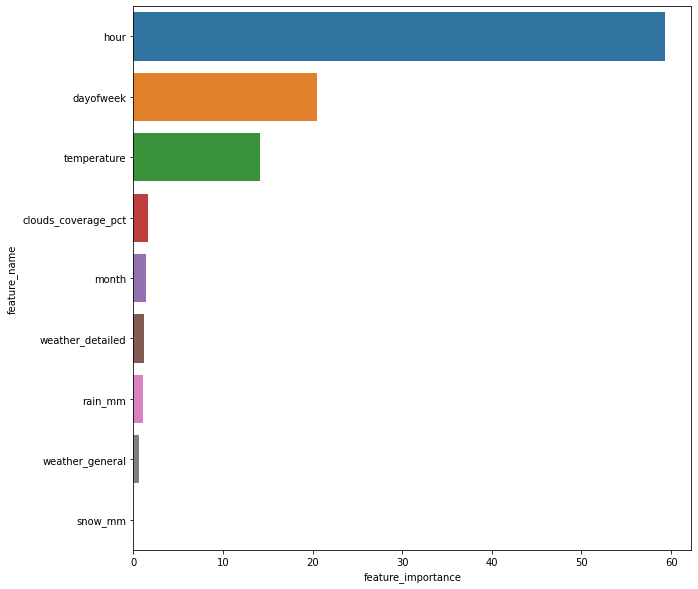

In [52]:
plt.figure(figsize=(10, 10))
sns.barplot(y='feature_name', x='feature_importance', data=feature_importance_df, orient='h')
plt.show()

## Out-of-sample prediction

GBRT showed the best MAPE on the holdout set, so we'll use it to make predictions for the out-of-sample observations

Expected MAPE: 85%

In [53]:
traffic_test_df = pd.read_csv('data/traffic_test.csv', parse_dates=['date_time'])

In [54]:
output_df = pd.DataFrame()
output_df['date_time'] = traffic_test_df['date_time']

In [55]:
traffic_test_df.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm
0,2019-01-01 00:00:00,Mist,mist,90,-0.2,0,0
1,2019-01-01 00:00:00,Haze,haze,90,-0.2,0,0
2,2019-01-01 00:00:00,Snow,light snow,90,-0.2,0,0
3,2019-01-01 00:00:00,Drizzle,light intensity drizzle,90,-0.2,0,0
4,2019-01-01 01:00:00,Mist,mist,90,-0.2,0,0


In [56]:
traffic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            10591 non-null  datetime64[ns]
 1   weather_general      10591 non-null  object        
 2   weather_detailed     10591 non-null  object        
 3   clouds_coverage_pct  10591 non-null  int64         
 4   temperature          10591 non-null  float64       
 5   rain_mm              10591 non-null  int64         
 6   snow_mm              10591 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 579.3+ KB


Applying the same transformations to data as we do in training: feature engineering and cleaning

In [57]:
traffic_test_df = feature_engineering(traffic_test_df)
traffic_test_df = clean_df(traffic_test_df, train_data=False)

In [58]:
traffic_test_df

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,hour,month,dayofweek
0,2019-01-01 00:00:00,Mist,mist,90,-0.2,0,0,0,1,1
1,2019-01-01 00:00:00,Haze,haze,90,-0.2,0,0,0,1,1
2,2019-01-01 00:00:00,Snow,light snow,90,-0.2,0,0,0,1,1
3,2019-01-01 00:00:00,Drizzle,light intensity drizzle,90,-0.2,0,0,0,1,1
4,2019-01-01 01:00:00,Mist,mist,90,-0.2,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
10586,2019-12-31 19:00:00,Mist,mist,90,-10.1,0,0,19,12,1
10587,2019-12-31 20:00:00,Snow,light snow,90,-9.9,0,0,20,12,1
10588,2019-12-31 21:00:00,Snow,light snow,90,-9.6,0,0,21,12,1
10589,2019-12-31 22:00:00,Snow,light snow,90,-10.2,0,0,22,12,1


In [59]:
X_predict = traffic_test_df[cat_features + num_features]

In [60]:
output_df['traffic'] = cb.predict(X_predict)

In [61]:
output_df

,date_time,traffic
0,2019-01-01 00:00:00,376.912456
1,2019-01-01 00:00:00,377.274683
2,2019-01-01 00:00:00,377.206394
3,2019-01-01 00:00:00,377.274683
4,2019-01-01 01:00:00,376.912456
...,...,...
10586,2019-12-31 19:00:00,673.955391
10587,2019-12-31 20:00:00,714.603135
10588,2019-12-31 21:00:00,714.603135
10589,2019-12-31 22:00:00,714.603135


In [62]:
output_df.to_csv('regression_predictions.csv', index=False)